# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.v2 as transforms
from IPython.display import clear_output
from skimage.io import imread, imsave
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

import transforms3d as T
from dataset3d import BNSet, BNSetMasks, get_dloader_mask
from model3d import CNN3d
from util3d import show_volume, get_saliency3d, get_obj_score3d

In [3]:
data_dir = "../data/bugNIST_DATA"

name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

device = "cuda" if torch.cuda.is_available() else "cpu"

# Training loop

In [4]:
lr = 1e-4

batch_size = 16
num_workers = 8

subset = ["ac", "bc"]

trainloader = get_dloader_mask(
"train", batch_size, data_dir=data_dir, subset=subset, num_workers=num_workers, pin_memory=True, persistent_workers=True
)

model = CNN3d(len(subset))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [5]:
model.train()

stats = {}
for epoch in range(50):
    metrics_train = {
        "loss": [],
        "preds": [],
        "labels": [],
    }

    print(f"Epoch {epoch}")
    for volumes, labels, masks in tqdm(trainloader):
        out = model((volumes * masks).to(device))

        loss = criterion(out, labels.type(torch.LongTensor).to(device))
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, indices = torch.max(out.cpu(), 1)

        metrics_train["loss"].append(loss.cpu().detach().item())
        metrics_train["preds"].append(indices.detach().numpy())
        metrics_train["labels"].append(labels.numpy())

    performance = {
        "loss": np.mean(metrics_train["loss"]),
        "accuracy": np.mean(
            np.concatenate(metrics_train["preds"])
            == np.concatenate(metrics_train["labels"])
        ).item(),
    }
    print(performance)
    stats[epoch] = performance

Epoch 0


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6633376950217832, 'accuracy': 0.6208754208754209}
Epoch 1


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6294264396031698, 'accuracy': 0.6579124579124579}
Epoch 2


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6130346687891151, 'accuracy': 0.674074074074074}
Epoch 3


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6136111091541988, 'accuracy': 0.663973063973064}
Epoch 4


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.6044250733108931, 'accuracy': 0.6855218855218855}
Epoch 5


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5912254776365014, 'accuracy': 0.7070707070707071}
Epoch 6


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.585852692204137, 'accuracy': 0.696969696969697}
Epoch 7


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5785750698658728, 'accuracy': 0.7037037037037037}
Epoch 8


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.562885356526221, 'accuracy': 0.7232323232323232}
Epoch 9


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5519720719706628, 'accuracy': 0.7212121212121212}
Epoch 10


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5490383617980505, 'accuracy': 0.7292929292929293}
Epoch 11


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5432481176109725, 'accuracy': 0.7346801346801347}
Epoch 12


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5306008631183255, 'accuracy': 0.7373737373737373}
Epoch 13


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5263531015765283, 'accuracy': 0.7441077441077442}
Epoch 14


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5332621174153461, 'accuracy': 0.7488215488215488}
Epoch 15


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5424982520841783, 'accuracy': 0.731986531986532}
Epoch 16


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5138918851972908, 'accuracy': 0.762962962962963}
Epoch 17


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5180544930119668, 'accuracy': 0.7575757575757576}
Epoch 18


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5141216029403031, 'accuracy': 0.762962962962963}
Epoch 19


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5067958512934305, 'accuracy': 0.7562289562289563}
Epoch 20


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4992780115014763, 'accuracy': 0.7616161616161616}
Epoch 21


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.49408257119758153, 'accuracy': 0.7710437710437711}
Epoch 22


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.510166452136091, 'accuracy': 0.7602693602693603}
Epoch 23


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4944431770552871, 'accuracy': 0.7683501683501683}
Epoch 24


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.5051024399136984, 'accuracy': 0.7609427609427609}
Epoch 25


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.49805037709333566, 'accuracy': 0.7703703703703704}
Epoch 26


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.47724253516043386, 'accuracy': 0.7717171717171717}
Epoch 27


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4663251845106002, 'accuracy': 0.7845117845117845}
Epoch 28


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.47421027735997273, 'accuracy': 0.7777777777777778}
Epoch 29


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.48288542208492113, 'accuracy': 0.7804713804713804}
Epoch 30


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4627501012817506, 'accuracy': 0.7851851851851852}
Epoch 31


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.46190217874383416, 'accuracy': 0.7872053872053872}
Epoch 32


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4643024417661851, 'accuracy': 0.7865319865319865}
Epoch 33


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4644243351874813, 'accuracy': 0.7885521885521886}
Epoch 34


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.46377022724638706, 'accuracy': 0.7885521885521886}
Epoch 35


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4506017605784119, 'accuracy': 0.793939393939394}
Epoch 36


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.46227504136741804, 'accuracy': 0.7912457912457912}
Epoch 37


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.45420916570771125, 'accuracy': 0.7831649831649832}
Epoch 38


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4676904861004122, 'accuracy': 0.775084175084175}
Epoch 39


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.43718786201169413, 'accuracy': 0.795959595959596}
Epoch 40


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4497985335127, 'accuracy': 0.7878787878787878}
Epoch 41


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.44527875832332076, 'accuracy': 0.8053872053872054}
Epoch 42


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.45979720241920924, 'accuracy': 0.7885521885521886}
Epoch 43


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4371484268096186, 'accuracy': 0.793939393939394}
Epoch 44


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4300726141019534, 'accuracy': 0.8006734006734006}
Epoch 45


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.43721545944290774, 'accuracy': 0.8047138047138047}
Epoch 46


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.44432964536451525, 'accuracy': 0.795959595959596}
Epoch 47


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4187810566797051, 'accuracy': 0.8208754208754209}
Epoch 48


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.4227193818297437, 'accuracy': 0.8080808080808081}
Epoch 49


  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 0.41178511179262595, 'accuracy': 0.806060606060606}


In [52]:
import seaborn as sns

In [53]:
sns.set_theme()

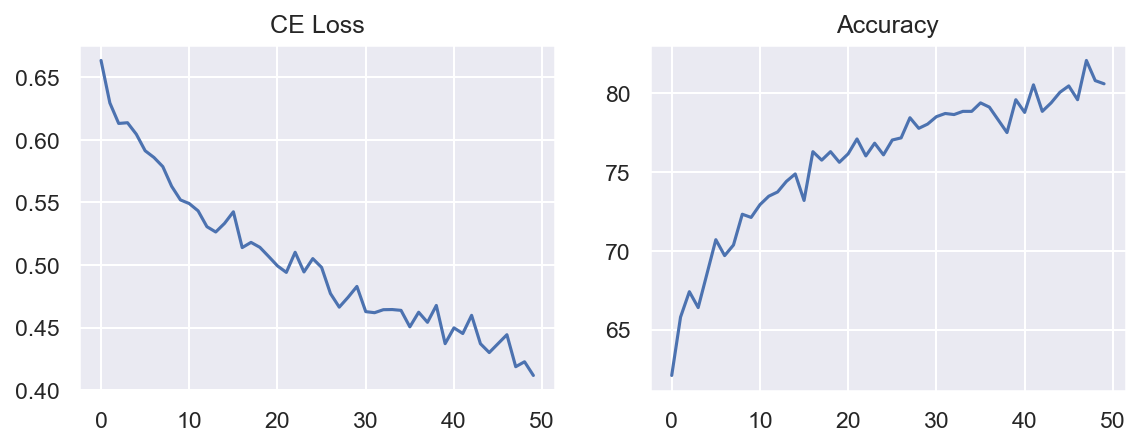

In [65]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 3), dpi=150)

ax0.plot(stats.keys(), [stats[epoch]['loss'] for epoch in stats])
ax0.set_title('CE Loss')

ax1.plot(stats.keys(), [stats[epoch]['accuracy'] * 100 for epoch in stats])
ax1.set_title('Accuracy')
plt.show()

# Saliency

In [6]:
dloader = get_dloader_mask(
    "train", 1, data_dir=data_dir, subset=subset, num_workers=0
)
model.eval();

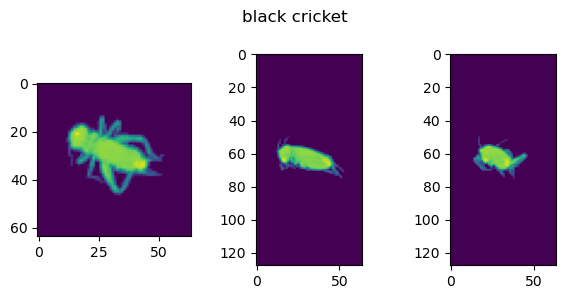

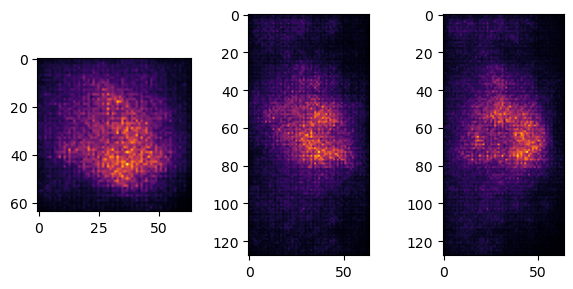

(0.7180044645636265, 1, 1)

In [41]:
volumes, labels, masks = next(iter(dloader))
volumes = volumes * masks

slc, score, indices, out = get_saliency3d(model, volumes, device=device)
obj_score = get_obj_score3d(slc, masks)

slc_abs = np.abs(slc)

show_volume(volumes.detach().numpy(), labels.item())
show_volume(slc_abs / slc_abs.max(), cmap="inferno")
obj_score, indices.item(), labels.item()

In [8]:
obj_scores = []
for volumes, labels, masks in tqdm(dloader):
    volumes *= masks

    slc, score, indices, out = get_saliency3d(model, volumes, device=device)
    obj_score = get_obj_score3d(slc, masks)

    obj_scores.append(obj_score)

np.mean(obj_scores)

  0%|          | 0/1485 [00:00<?, ?it/s]

0.6883748505302948